# Beautiful Graph codes are from here

https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

I Really appriciate for Everyone who provide EDA Information

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore') # 경고 메시지 생략

train=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
test=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/test.csv')
submission=pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv')

train.head()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [2]:
t_copy= train.copy()
t_copy

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [3]:
from sklearn.preprocessing import StandardScaler 

std_scaler = StandardScaler()
t_copy2 = t_copy.drop('expert_consensus',axis=1) #drop object label

feature = t_copy2.columns
print(feature)

for idx, feature in enumerate(t_copy2.columns):
    t_copy2[feature] = std_scaler.fit_transform(t_copy2[[feature]]) #normalize

Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote',
       'grda_vote', 'other_vote'],
      dtype='object')


In [4]:
t_copy2

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,-0.386104,-0.376823,-0.377730,-1.695809,-0.419339,-0.358979,-1.621954,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
1,-0.386104,-0.362488,-0.358655,-1.695809,-0.409751,-0.354841,1.406297,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
2,-0.386104,-0.348152,-0.352297,-1.695809,-0.400162,-0.353461,-0.804360,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
3,-0.386104,-0.333817,-0.320506,-1.695809,-0.390574,-0.346563,0.465163,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
4,-0.386104,-0.319482,-0.301432,-1.695809,-0.380985,-0.342425,0.756418,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,-1.420885,-0.290811,-0.339581,1.716817,-0.361808,-0.350702,1.654443,-1.184232,-0.570566,-0.403991,-0.403888,0.960181,-0.475295,-0.542998
106796,-1.420885,-0.276475,-0.333222,1.716817,-0.352220,-0.349323,-1.490353,-1.184232,-0.570566,-0.403991,-0.403888,0.960181,-0.475295,-0.542998
106797,-1.420885,-0.262140,-0.326864,1.716817,-0.342631,-0.347943,-1.353007,-1.184232,-0.570566,-0.403991,-0.403888,0.960181,-0.475295,-0.542998
106798,-1.420885,-0.247805,-0.320506,1.716817,-0.333043,-0.346563,1.324673,-1.184232,-0.570566,-0.403991,-0.403888,0.960181,-0.475295,-0.542998


In [5]:
t_copy2.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05
mean,8.068452e-17,-2.528148e-17,2.514842e-17,1.000614e-16,-2.128967e-18,-1.024565e-17,4.497443e-17,-6.919143e-18,1.809622e-17,6.772776e-17,-1.689868e-17,-1.869499e-17,-3.592632e-17,-9.134599e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.705755e+00,-3.768233e-01,-3.777296e-01,-1.695809e+00,-4.193395e-01,-3.589793e-01,-1.724633e+00,-1.739575e+00,-5.705658e-01,-4.039910e-01,-4.038876e-01,-4.437949e-01,-4.752946e-01,-5.429975e-01
25%,-8.736197e-01,-3.624879e-01,-3.586551e-01,-8.637122e-01,-4.001625e-01,-3.507021e-01,-8.649646e-01,-8.413710e-01,-5.705658e-01,-4.039910e-01,-4.038876e-01,-4.437949e-01,-4.752946e-01,-5.429975e-01
50%,-2.680608e-02,-3.051463e-01,-2.950735e-01,-1.487442e-02,-3.426315e-01,-3.162134e-01,-2.482804e-03,-1.275365e-02,-5.705658e-01,-4.039910e-01,-4.038876e-01,-4.437949e-01,-4.752946e-01,-5.429975e-01
75%,8.662477e-01,-1.474567e-01,-1.170449e-01,8.836332e-01,-1.412730e-01,-8.720892e-02,8.669021e-01,8.486071e-01,7.926333e-02,-4.923414e-02,-4.038876e-01,2.419711e-02,-2.655861e-02,9.311159e-03
max,1.776093e+00,1.026005e+01,1.034213e+01,1.716817e+00,9.370516e+00,1.180309e+01,1.734381e+00,1.790343e+00,1.177619e+01,5.981632e+00,4.704875e+00,6.576085e+00,6.255745e+00,6.360861e+00


In [6]:
#for idx,feature in enumerate(t_copy2.columns):
 #   t_copy2[(t_copy2[feature] >= 3)]= 3
  #  t_copy2[(t_copy2[feature] <= -3)]= -3 #change 3 parameters
#t_copy3=t_copy2.copy()

In [7]:
#count = t_copy3[t_copy3[feature] >=3].count()
count2 = t_copy2[t_copy2[feature] >=3].count()
#count3 = t_copy3[t_copy3[feature] <=-3].count()
count4 = t_copy2[t_copy2[feature] <=-3].count()
#print(count)
print(count2)
#print(count3)
print(count4)

eeg_id                              3559
eeg_sub_id                          3559
eeg_label_offset_seconds            3559
spectrogram_id                      3559
spectrogram_sub_id                  3559
spectrogram_label_offset_seconds    3559
label_id                            3559
patient_id                          3559
seizure_vote                        3559
lpd_vote                            3559
gpd_vote                            3559
lrda_vote                           3559
grda_vote                           3559
other_vote                          3559
dtype: int64
eeg_id                              0
eeg_sub_id                          0
eeg_label_offset_seconds            0
spectrogram_id                      0
spectrogram_sub_id                  0
spectrogram_label_offset_seconds    0
label_id                            0
patient_id                          0
seizure_vote                        0
lpd_vote                            0
gpd_vote                         

In [8]:
normalized_train =t_copy2.copy()
#normalized_train =t_copy3.copy()
normalized_train

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,-0.386104,-0.376823,-0.377730,-1.695809,-0.419339,-0.358979,-1.621954,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
1,-0.386104,-0.362488,-0.358655,-1.695809,-0.409751,-0.354841,1.406297,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
2,-0.386104,-0.348152,-0.352297,-1.695809,-0.400162,-0.353461,-0.804360,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
3,-0.386104,-0.333817,-0.320506,-1.695809,-0.390574,-0.346563,0.465163,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
4,-0.386104,-0.319482,-0.301432,-1.695809,-0.380985,-0.342425,0.756418,0.550842,1.378922,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,-1.420885,-0.290811,-0.339581,1.716817,-0.361808,-0.350702,1.654443,-1.184232,-0.570566,-0.403991,-0.403888,0.960181,-0.475295,-0.542998
106796,-1.420885,-0.276475,-0.333222,1.716817,-0.352220,-0.349323,-1.490353,-1.184232,-0.570566,-0.403991,-0.403888,0.960181,-0.475295,-0.542998
106797,-1.420885,-0.262140,-0.326864,1.716817,-0.342631,-0.347943,-1.353007,-1.184232,-0.570566,-0.403991,-0.403888,0.960181,-0.475295,-0.542998
106798,-1.420885,-0.247805,-0.320506,1.716817,-0.333043,-0.346563,1.324673,-1.184232,-0.570566,-0.403991,-0.403888,0.960181,-0.475295,-0.542998


In [9]:
normalized_train.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05,1.068000e+05
mean,8.068452e-17,-2.528148e-17,2.514842e-17,1.000614e-16,-2.128967e-18,-1.024565e-17,4.497443e-17,-6.919143e-18,1.809622e-17,6.772776e-17,-1.689868e-17,-1.869499e-17,-3.592632e-17,-9.134599e-17
std,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00,1.000005e+00
min,-1.705755e+00,-3.768233e-01,-3.777296e-01,-1.695809e+00,-4.193395e-01,-3.589793e-01,-1.724633e+00,-1.739575e+00,-5.705658e-01,-4.039910e-01,-4.038876e-01,-4.437949e-01,-4.752946e-01,-5.429975e-01
25%,-8.736197e-01,-3.624879e-01,-3.586551e-01,-8.637122e-01,-4.001625e-01,-3.507021e-01,-8.649646e-01,-8.413710e-01,-5.705658e-01,-4.039910e-01,-4.038876e-01,-4.437949e-01,-4.752946e-01,-5.429975e-01
50%,-2.680608e-02,-3.051463e-01,-2.950735e-01,-1.487442e-02,-3.426315e-01,-3.162134e-01,-2.482804e-03,-1.275365e-02,-5.705658e-01,-4.039910e-01,-4.038876e-01,-4.437949e-01,-4.752946e-01,-5.429975e-01
75%,8.662477e-01,-1.474567e-01,-1.170449e-01,8.836332e-01,-1.412730e-01,-8.720892e-02,8.669021e-01,8.486071e-01,7.926333e-02,-4.923414e-02,-4.038876e-01,2.419711e-02,-2.655861e-02,9.311159e-03
max,1.776093e+00,1.026005e+01,1.034213e+01,1.716817e+00,9.370516e+00,1.180309e+01,1.734381e+00,1.790343e+00,1.177619e+01,5.981632e+00,4.704875e+00,6.576085e+00,6.255745e+00,6.360861e+00


In [10]:
def resumetable(df):
    print(f'데이터 세트 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    
    summary['결측값 개수'] = df.isnull().sum().values #결측값 개수 열 추가
    summary['고윳값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    for col in df.columns: #데이터 종류 추가
        if 'id' in col:
            summary.loc[col, '데이터 종류'] = 'id형'
        elif df[col].dtype == object:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif 'vote' in col:
            summary.loc[col, '데이터 종류'] = '투표형'
    summary['첫 번째 값'] = df.loc[0].values #첫째값
    summary['두 번째 값'] = df.loc[1].values #둘째값
    return summary


summary=resumetable(normalized_train)
summary = summary.reset_index() #그렇게 구한 서버리를 index 리셋
summary = summary.rename(columns={'index': '피처'}) #피처를 
summary

데이터 세트 형상: (106800, 14)


,피처,데이터 타입,결측값 개수,고윳값 개수,데이터 종류,첫 번째 값,두 번째 값
0,eeg_id,float64,0,17089,id형,-0.386104,-0.386104
1,eeg_sub_id,float64,0,743,id형,-0.376823,-0.362488
2,eeg_label_offset_seconds,float64,0,1502,연속형,-0.377730,-0.358655
3,spectrogram_id,float64,0,11138,id형,-1.695809,-1.695809
4,spectrogram_sub_id,float64,0,1022,id형,-0.419339,-0.409751
5,spectrogram_label_offset_seconds,float64,0,4686,연속형,-0.358979,-0.354841
6,label_id,float64,0,106800,id형,-1.621954,1.406297
7,patient_id,float64,0,1950,id형,0.550842,0.550842
8,seizure_vote,float64,0,18,연속형,1.378922,1.378922
9,lpd_vote,float64,0,19,연속형,-0.403991,-0.403991


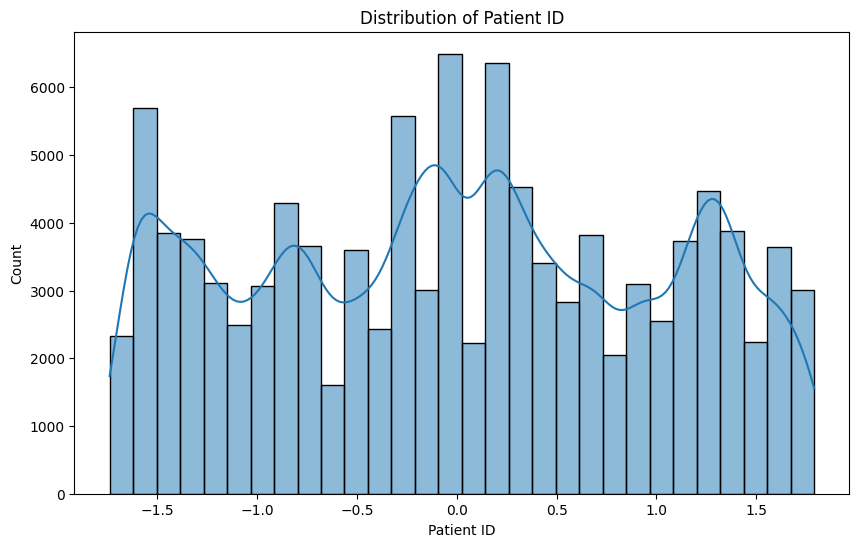

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(normalized_train['patient_id'], bins=30, kde=True)
plt.title('Distribution of Patient ID')
plt.xlabel('Patient ID')
plt.ylabel('Count')
plt.show()

#  Not normalized even after nomalize..?

should be more nomalized

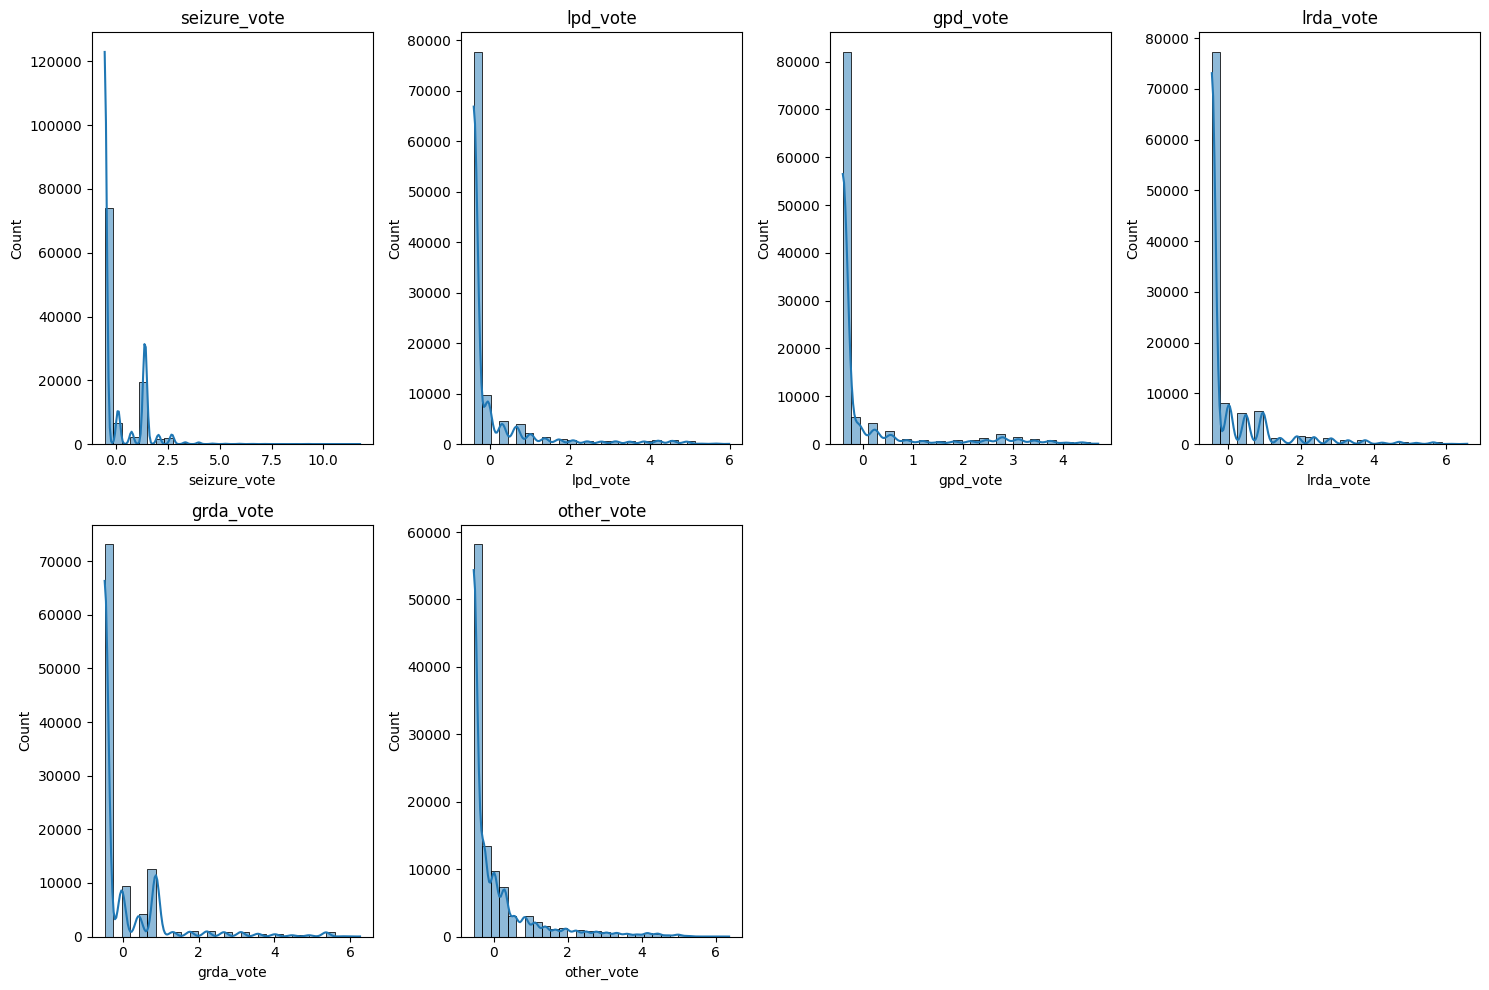

In [12]:
targets = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']

plt.figure(figsize=(15, 10))
for i, column in enumerate(targets, 1):
    plt.subplot(2, 4, i)
    sns.histplot(normalized_train[column], kde=True, bins=30)
    plt.title(column)
plt.tight_layout()

In [13]:
for feature in targets:
    print('{0}의 와도 {1:0.4f}'.format(feature, normalized_train[feature].skew())) #데이터 프레임 내 컬럼을 먼저 입력하고, 그 뒤에 skew나 kurt
    print('{0}의 첨도 {1:0.4f}'.format(feature,normalized_train[feature].kurt()))


seizure_vote의 와도 2.1786
seizure_vote의 첨도 8.2089
lpd_vote의 와도 3.2892
lpd_vote의 첨도 11.0523
gpd_vote의 와도 2.7555
gpd_vote의 첨도 6.6558
lrda_vote의 와도 3.0784
lrda_vote의 첨도 10.5619
grda_vote의 와도 3.0782
grda_vote의 첨도 10.8868
other_vote의 와도 2.7001
other_vote의 첨도 7.8044


In [14]:
x_train = normalized_train

In [15]:
from sklearn.preprocessing import LabelEncoder # 레이블 인코더

# 레이블 인코더 생성
label_encoder = LabelEncoder()
# 레이블 인코딩 적용
y_train = label_encoder.fit_transform(train['expert_consensus'])

In [16]:
y_train

array([5, 5, 5, ..., 3, 3, 3])

In [17]:
y_train

array([5, 5, 5, ..., 3, 3, 3])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=0)

In [19]:
print(y_train)

[5 1 1 ... 3 0 0]


In [20]:
import lightgbm as lgb
print(lgb.__version__)

4.2.0


In [21]:
X_train.describe()

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
count,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000,85440.000000
mean,-0.001136,-0.000138,0.000652,-0.000559,-0.002977,-0.003497,-0.000156,0.000396,0.002796,-0.000011,0.000343,-0.002325,-0.000325,-0.000873
std,0.999688,0.998254,1.001540,0.999551,0.993086,0.987727,0.999853,0.999931,1.004552,1.001044,0.999157,0.997712,1.001387,0.998091
min,-1.705755,-0.376823,-0.377730,-1.695809,-0.419339,-0.358979,-1.724633,-1.739575,-0.570566,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
25%,-0.873005,-0.362488,-0.358655,-0.864071,-0.400162,-0.350702,-0.864718,-0.841371,-0.570566,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
50%,-0.032642,-0.305146,-0.295073,-0.017762,-0.342631,-0.316213,-0.002743,-0.012754,-0.570566,-0.403991,-0.403888,-0.443795,-0.475295,-0.542998
75%,0.866248,-0.147457,-0.117045,0.883633,-0.141273,-0.088588,0.866648,0.848607,0.079263,-0.049234,-0.403888,0.024197,-0.026559,0.009311
max,1.776093,10.260052,10.342131,1.716817,9.370516,11.803092,1.734381,1.790343,11.776188,5.981632,4.704875,6.576085,6.255745,6.360861


In [22]:
import numpy as np

def custom_kldiv(y_true, y_pred):
    eps = 1e-15  # 로그를 계산할 때 0으로 나누는 것을 방지하기 위한 아주 작은 값
    y_true = np.clip(y_true, eps, 1 - eps)  # 0 또는 1로 나누는 것을 방지하기 위해 예측된 확률 값을 클립합니다.
    y_pred = np.clip(y_pred, eps, 1 - eps)  # 0 또는 1로 나누는 것을 방지하기 위해 실제 타겟 값을 클립합니다.
    kldiv = np.mean(np.sum(y_true * np.log(y_true / y_pred + eps), axis=1))  # KLDiv 계산
    return 'kldiv', kldiv, False  # 반환값 형식 수정

In [23]:
import lightgbm as lgb

# LightGBM 하이퍼파라미터
params = {'num_class' : 6,
          'objective': 'multiclass',
          'metric' : 'multi_logloss',
          'num_leaves': 255,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 10
          }

#cat_features = ['expert_consensus']

# LightGBM 훈련 및 검증 데이터셋
dtrain = lgb.Dataset(X_train.astype(float), label=y_train.astype(float))  # 데이터를 실수형식으로 변환하여 사용
dvalid = lgb.Dataset(X_valid.astype(float), label=y_valid.astype(float))
 
# LightGBM 모델 훈련
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                    callbacks=[
        lgb.early_stopping(stopping_rounds=150),
        lgb.log_evaluation(period=100)
    ]
                    
                      ) 

[LightGBM] [Info] Total Bins 2158
[LightGBM] [Info] Number of data points in the train set: 85440, number of used features: 14
[LightGBM] [Info] Start training from score -1.852858
[LightGBM] [Info] Start training from score -1.736436
[LightGBM] [Info] Start training from score -1.970016
[LightGBM] [Info] Start training from score -1.862384
[LightGBM] [Info] Start training from score -1.738032
[LightGBM] [Info] Start training from score -1.627388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 150 rounds
[100]	training's multi_logloss: 0.66374	valid_1's multi_logloss: 0.668669
[200]	training's multi_logloss: 0.2941

In [24]:
num_trees = lgb_model.num_trees()
print(num_trees)

9000


In [25]:
y_pred = lgb_model.predict(X_valid)

In [26]:
print(y_pred)
y_pred.shape

[[5.27173918e-06 4.45504202e-06 4.93421416e-06 4.30177595e-06
  9.99945327e-01 3.57106476e-05]
 [4.50482508e-06 2.38833935e-06 9.99971477e-01 2.58198001e-06
  1.60545756e-05 2.99305441e-06]
 [1.13630518e-06 1.39442803e-06 1.10757938e-06 1.05324491e-06
  1.33323993e-06 9.99993975e-01]
 ...
 [9.99994271e-01 1.13173839e-06 9.73500928e-07 1.02813625e-06
  1.19438508e-06 1.40152732e-06]
 [1.47782217e-06 9.99992226e-01 1.17151883e-06 1.51897010e-06
  2.01814111e-06 1.58776790e-06]
 [1.15108490e-06 1.18429343e-06 1.14619492e-06 1.05653037e-06
  1.53843310e-06 9.99993923e-01]]


(21360, 6)

In [27]:
pred = np.mean(y_pred,axis=0)

In [28]:
print(pred)

[0.15482003 0.17842488 0.13772441 0.15782487 0.17704892 0.19415689]


In [29]:
submission=pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv")
labels=['seizure','lpd','gpd','lrda','grda','other']
for i in range(len(labels)):
    submission[f'{labels[i]}_vote']=pred[i]
submission.to_csv("submission.csv",index=None)
display(submission.head())

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,3911565283,0.15482,0.178425,0.137724,0.157825,0.177049,0.194157


In [30]:
# ubANITY CHECK TO CONFIRM PREDICTIONS SUM TO ONE
submission.iloc[:,-6:].sum(axis=1)

0    1.0
dtype: float64